# Stock Prices Prediction using GRU

## Fetch and clean the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from time import time

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,6)

In [2]:
data = pd.read_csv('NasdaqInc_stockdata_features.csv', index_col = 'Date')
data = data.replace([np.inf, -np.inf], np.nan).dropna() #replace infinite values by nan, and drop all rows with nans
data.head()

,Close,Adj Close,roll_mean,band1,band2,daily_ret,cumulative ret,roll_std,momentum,stochastic osc,Close Predict
Date,,,,,,,,,,,
2002-07-15,12.75,11.583749,13.480759,15.032896,11.928622,-0.150000,-0.150000,0.776068,-0.833253,0.0,11.356618
2002-07-16,12.50,11.356618,13.253626,15.297040,11.210213,-0.019608,-0.166667,1.021707,-0.166667,0.0,11.356618
2002-07-17,12.50,11.356618,13.014683,15.341358,10.688009,0.000000,-0.166667,1.163337,-0.173827,0.0,10.675220
2002-07-18,11.75,10.675220,12.719411,15.419645,10.019178,-0.060000,-0.216667,1.350117,-0.216667,0.0,9.539557
2002-07-19,10.50,9.539557,12.310573,15.577913,9.043233,-0.106383,-0.300000,1.633670,-0.300000,0.0,9.266995


##  Visualize the data

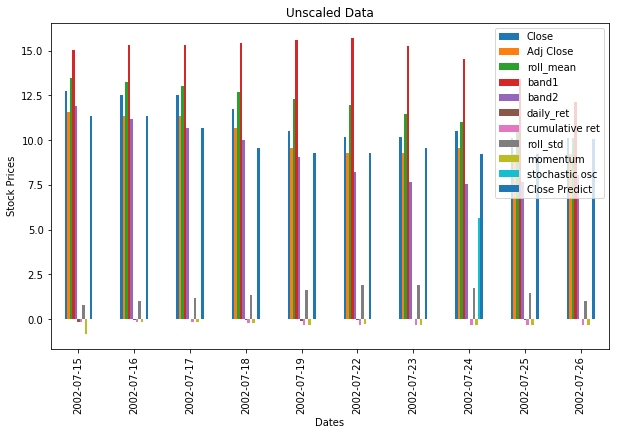

In [3]:
data[:10].plot(use_index = True, kind = 'bar')
plt.title('Unscaled Data')
plt.xlabel('Dates')
plt.ylabel('Stock Prices')
plt.show()

## Feature scaling

In [4]:
df = (data - data.mean()) / (data.max() - data.min())
print("DataFrame:", df.shape)
print("Standardization makes the mean close to zero. All feature values now lie between -1 and +1")
df.head()

DataFrame: (3753, 11)
Standardization makes the mean close to zero. All feature values now lie between -1 and +1


,Close,Adj Close,roll_mean,band1,band2,daily_ret,cumulative ret,roll_std,momentum,stochastic osc,Close Predict
Date,,,,,,,,,,,
2002-07-15,-0.263995,-0.253857,-0.226892,-0.220450,-0.229923,-0.366846,-0.253857,0.026571,-0.624699,-0.529126,-0.257532
2002-07-16,-0.267730,-0.257299,-0.230376,-0.216459,-0.240941,-0.049616,-0.257299,0.091776,-0.129362,-0.529126,-0.257532
2002-07-17,-0.267730,-0.257299,-0.234041,-0.215790,-0.248950,-0.001912,-0.257299,0.129373,-0.134682,-0.529126,-0.267858
2002-07-18,-0.278936,-0.267624,-0.238571,-0.214607,-0.259208,-0.147886,-0.267624,0.178954,-0.166516,-0.529126,-0.285067
2002-07-19,-0.297612,-0.284833,-0.244842,-0.212216,-0.274176,-0.260731,-0.284833,0.254224,-0.228441,-0.529126,-0.289197


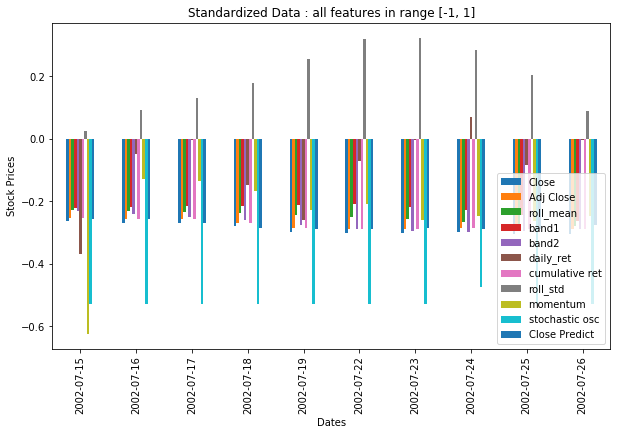

In [5]:
df[:10].plot(use_index = True, kind = 'bar')
plt.title('Standardized Data : all features in range [-1, 1]')
plt.xlabel('Dates')
plt.ylabel('Stock Prices')
plt.show()

## Training and test sets

In [6]:
col_names = list(df)
feature_names = col_names[:-1]
n_features = len(feature_names)
target_name = col_names[-1]
print("Columns present:", col_names)
print("All except '{}' are features- '{}' are the values that our model needs to predict".format(target_name, target_name))
print("Data consists of {} features".format(n_features))

print("   ")

train_test_ratio = 0.75
df_train = df[:int(df.shape[0]*train_test_ratio)]
df_test = df[int(df.shape[0]*train_test_ratio):]

X_train = df_train[feature_names].as_matrix()
y_train = df_train[target_name].as_matrix()

X_test = df_test[feature_names].as_matrix()
y_test = df_test[target_name].as_matrix()

print("Training data,", X_train.shape, "and labels,", y_train.shape)
print("Test data,", X_test.shape, "and labels,", y_test.shape)

Columns present: ['Close', 'Adj Close', 'roll_mean', 'band1', 'band2', 'daily_ret', 'cumulative ret', 'roll_std', 'momentum', 'stochastic osc', 'Close Predict']
All except 'Close Predict' are features- 'Close Predict' are the values that our model needs to predict
Data consists of 10 features
   
Training data, (2814, 10) and labels, (2814,)
Test data, (939, 10) and labels, (939,)


##  Initialize parameters

In [7]:
batch_size = 1  #feed batch_size subsequences at a time

series_len = X_train.shape[0]   #length of the time series 
print("In training set, the sequence is", series_len, "long")

n_steps = 4    #feed the model in truncated subsequences 
print("It has been truncated to subsequences of length = ", n_steps)

n_classes = 1 #model will output a single number
n_batches = series_len//batch_size//n_steps 
print("Hence we feed the model", n_batches, "batches, each containing", batch_size, "subsequence") 
print("This means, while training, the error is backpropagated only", n_steps, "time steps" )

In training set, the sequence is 2814 long
It has been truncated to subsequences of length =  4
Hence we feed the model 703 batches, each containing 1 subsequence
This means, while training, the error is backpropagated only 4 time steps


## 1: Single Layer GRU

###  Design the network

In [8]:
n_hidden = 40 #number of neurons

#Initialize placeholders
X = tf.placeholder(shape=[None, n_steps, n_features], dtype=tf.float32)  
y = tf.placeholder(shape=[None, n_steps, n_classes], dtype=tf.float32) 
labels = tf.unstack(y, axis=1)  

#Create the GRU
cell = tf.contrib.rnn.GRUCell(n_hidden)
output, state = tf.nn.dynamic_rnn(cell = cell, inputs = X, dtype = tf.float32)  
print("Network containing ", n_hidden, "GRUs generates output of shape", output.get_shape())

stacked_GRU_outputs = tf.reshape(output, [-1, n_hidden]) 
labels = tf.gather(params = labels, indices = 2)     
print("Output finally reshaped to", stacked_GRU_outputs.get_shape(), "and labels reshaped to", labels.get_shape())

from tensorflow.contrib.layers import fully_connected
n_outputs = 1
logits = fully_connected(stacked_GRU_outputs, n_outputs, activation_fn = None)
print("Fully connected layer's output of shape", logits.get_shape())

#Evaluation metrics
loss = tf.reduce_mean(tf.square(logits - labels))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train_op = optimizer.minimize(loss)  

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

path = "./1_GRU40n10e.1"
saver = tf.train.Saver()

Network containing  40 GRUs generates output of shape (?, 4, 40)
Output finally reshaped to (?, 40) and labels reshaped to (?, 1)
Fully connected layer's output of shape (?, 1)


###  Train the model

In [9]:
def train_model(path, use_dropout = False):
    n_epochs = 10
    train_loss_log = []       
    display_step = 1

    #Parameters for early stopping
    min_loss = np.infty
    epochs_without_improvement = 0 
    max_epochs_without_improvement = 20 
    
    start = time()
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            i1 = batch * n_steps
            i2 = i1 + n_steps*batch_size

            X_batch = X_train[i1:i2, :]
            X_batch = X_batch.reshape(batch_size, n_steps, n_features)
            y_batch = y_train[i1:i2]
            y_batch = y_batch.reshape(batch_size, n_steps, 1)

            train_op_, loss_ =  sess.run([train_op, loss], feed_dict={X: X_batch, y: y_batch})
            if use_dropout:
                train_op_, loss_ =  sess.run([train_op, loss], feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
                
            train_loss_log.append(loss_)

        if(epoch % display_step == 0):
                print('Epoch {}: MSE = {}'.format(epoch, loss_))
        save_path = saver.save(sess, path)
    print("Training took {} minutes".format((time() - start)/60))
    return train_loss_log
        
train_loss_log = train_model(path)

Epoch 0: MSE = 0.00011994245869573206
Epoch 1: MSE = 2.8417629437171854e-05
Epoch 2: MSE = 2.060322731267661e-05
Epoch 3: MSE = 1.8261136574437842e-05
Epoch 4: MSE = 1.5501955203944817e-05
Epoch 5: MSE = 1.3018216122873127e-05
Epoch 6: MSE = 1.1109052138635889e-05
Epoch 7: MSE = 9.819892511586659e-06
Epoch 8: MSE = 9.050545486388728e-06
Epoch 9: MSE = 8.66522896103561e-06
Training took 0.9082246899604798 minutes


###  Evaluate the model

INFO:tensorflow:Restoring parameters from ./1_GRU40n10e.1


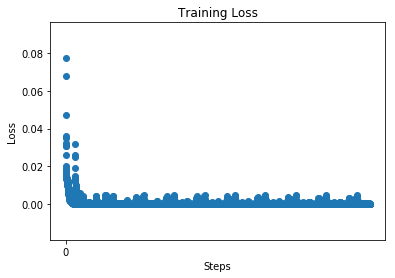

MSE reduced from 0.07729727029800415 to 8.66522896103561e-06
Model's R-squared score =  0.7445751909456192


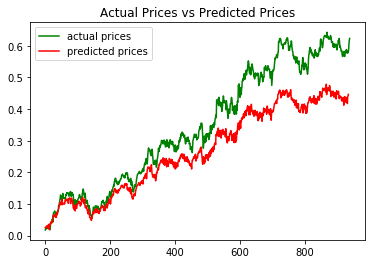

In [10]:
def evaluate_model(path, train_loss_log):
    
    saver.restore(sess, path)
    predictions = []
    y_true = []
    
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.title('Training Loss')
    plt.scatter(x = np.arange(0, len(train_loss_log)), y = train_loss_log)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    ax = plt.gca()
    ax.xaxis.set_ticks(np.arange(0, len(train_loss_log), 200000))
    plt.show()
    
    for i in range(len(X_test) - n_steps):
        X_test_batch = X_test[i:i+n_steps, :]
        X_test_batch = X_test_batch.reshape(1, n_steps, n_features)

        y_test_batch = y_test[i:i+n_steps]
        y_test_batch = y_test_batch.reshape((1, n_steps, 1))

        test_set_preds = sess.run(logits, feed_dict = {X: X_test_batch, y: y_test_batch})
        #test_set_preds has predictions of size= n_step (for each batch); we extract the prediction at the last time step
        predictions.append(test_set_preds[-1][0])
        y_true.append(y_test_batch[-1][0])
    
    #Measure R-squared: coefficient of determination
    from sklearn.metrics import r2_score
    model_r2 = r2_score(y_true, predictions)

    print("MSE reduced from {} to {}".format(train_loss_log[0], train_loss_log[-1]))
    print("Model's R-squared score = ", model_r2)

    #Visualize predictions
    plt.plot(y_test, label = 'actual prices', color='green')
    plt.plot(predictions, label='predicted prices',color='red')
    plt.title('Actual Prices vs Predicted Prices')
    plt.legend(loc = 'upper left')
    plt.show()
    
    return None
    
    return None

evaluate_model(path, train_loss_log)

## 2: Deep GRU

### Design the network

In [11]:
tf.reset_default_graph() #delete the previous graph

n_hidden = 100 #number of neurons in the hidden layer
n_layers = 3

#Initialize placeholders
X = tf.placeholder(shape=[None, n_steps, n_features], dtype=tf.float32)  
y = tf.placeholder(shape=[None, n_steps, n_classes], dtype=tf.float32) 
labels = tf.unstack(y, axis=1)  

#Create the GRU
GRU_layers = [tf.contrib.rnn.GRUCell(n_hidden) for layer in range(n_layers)] #create n_layers layers
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(GRU_layers)
output, state = tf.nn.dynamic_rnn(cell = multi_layer_cell, inputs = X, dtype = tf.float32)  
print("The hidden layer (GRU) containing", n_hidden, "memory units generates output of shape", output.get_shape())

stacked_GRU_outputs = tf.reshape(output, [-1, n_hidden]) 
labels = tf.gather(params = labels, indices = 2)     
print("GRU output finally reshaped to", stacked_GRU_outputs.get_shape(), "and labels reshaped to", labels.get_shape())

from tensorflow.contrib.layers import fully_connected
n_outputs = 1
logits = fully_connected(stacked_GRU_outputs, n_outputs, activation_fn = None)
print("Fully connected layer's output of shape", logits.get_shape())

#Evaluation metrics
loss = tf.reduce_mean(tf.square(logits - labels))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train_op = optimizer.minimize(loss)  

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
path = "./2_DGRU40n10e.1"
saver = tf.train.Saver()

The hidden layer (GRU) containing 100 memory units generates output of shape (?, 4, 100)
GRU output finally reshaped to (?, 100) and labels reshaped to (?, 1)
Fully connected layer's output of shape (?, 1)


###  Train the model

In [12]:
train_loss_log =  train_model(path)

Epoch 0: MSE = 0.0007800908642821014
Epoch 1: MSE = 5.9418322052806616e-05
Epoch 2: MSE = 8.6582986114081e-06
Epoch 3: MSE = 1.0224120160273742e-05
Epoch 4: MSE = 1.1517086022649892e-05
Epoch 5: MSE = 1.1560100574570242e-05
Epoch 6: MSE = 1.0889724762819242e-05
Epoch 7: MSE = 9.90716853266349e-06
Epoch 8: MSE = 8.847538083500694e-06
Epoch 9: MSE = 8.142511433106847e-06
Training took 1.5861814737319946 minutes


###  Evaluate the model

INFO:tensorflow:Restoring parameters from ./2_DGRU40n10e.1


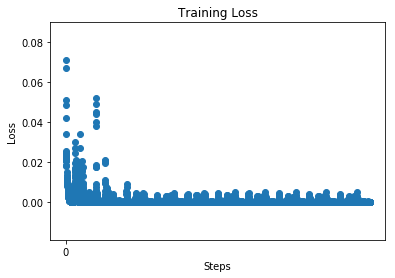

MSE reduced from 0.0710163339972496 to 8.142511433106847e-06
Model's R-squared score =  0.99249756969024


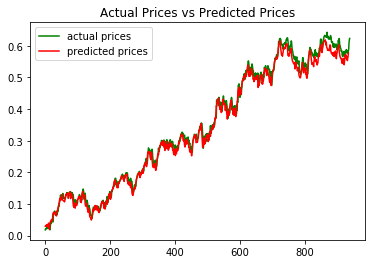

In [13]:
evaluate_model(path, train_loss_log)

## 3: Deep GRU Regularized with dropout

In [14]:
tf.reset_default_graph() #delete the previous graph

n_hidden = 100 #number of neurons in the hidden layer
n_layers = 3

#Initialize placeholders
X = tf.placeholder(shape=[None, n_steps, n_features], dtype=tf.float32)  
y = tf.placeholder(shape=[None, n_steps, n_classes], dtype=tf.float32) 
labels = tf.unstack(y, axis=1)  

#Create the GRU
keep_prob = tf.placeholder_with_default(1.0, shape=())
GRU_cells = [tf.contrib.rnn.GRUCell(num_units = n_hidden) for layer in range(n_layers)]
cells_dropped = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob = keep_prob) for cell in GRU_cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_dropped)
output, state = tf.nn.dynamic_rnn(cell = multi_layer_cell, inputs = X, dtype=tf.float32)
print("The hidden layer (GRU) containing", n_hidden, "memory units generates output of shape", output.get_shape())

stacked_GRU_outputs = tf.reshape(output, [-1, n_hidden]) 
labels = tf.gather(params = labels, indices = 2)     
print("GRU output finally reshaped to", stacked_GRU_outputs.get_shape(), "and labels reshaped to", labels.get_shape())

from tensorflow.contrib.layers import fully_connected
n_outputs = 1
logits = fully_connected(stacked_GRU_outputs, n_outputs, activation_fn = None)
print("Fully connected layer's output of shape", logits.get_shape())

#Evaluation metrics
loss = tf.reduce_mean(tf.square(logits - labels))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train_op = optimizer.minimize(loss)  

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
path = "./3_regDGRU40n10e.1"
saver = tf.train.Saver()

The hidden layer (GRU) containing 100 memory units generates output of shape (?, 4, 100)
GRU output finally reshaped to (?, 100) and labels reshaped to (?, 1)
Fully connected layer's output of shape (?, 1)


###  Train the model

In [15]:
train_keep_prob = 0.3
train_loss_log =  train_model(path, use_dropout = True)

Epoch 0: MSE = 0.001298298011533916
Epoch 1: MSE = 0.004639459773898125
Epoch 2: MSE = 0.0013551600277423859
Epoch 3: MSE = 0.00042767770355567336
Epoch 4: MSE = 0.0016226859297603369
Epoch 5: MSE = 0.0016393285477533937
Epoch 6: MSE = 0.0028687529265880585
Epoch 7: MSE = 0.0021841228008270264
Epoch 8: MSE = 0.002331868279725313
Epoch 9: MSE = 0.001540380297228694
Training took 2.8185013850529987 minutes


###  Evaluate the model

INFO:tensorflow:Restoring parameters from ./3_regDGRU40n10e.1


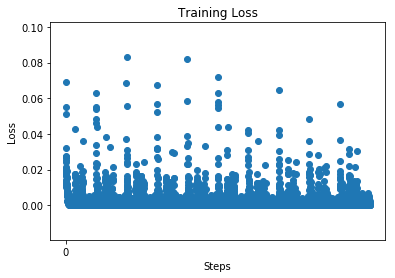

MSE reduced from 0.055295418947935104 to 0.001540380297228694
Model's R-squared score =  -1.8507378921952502


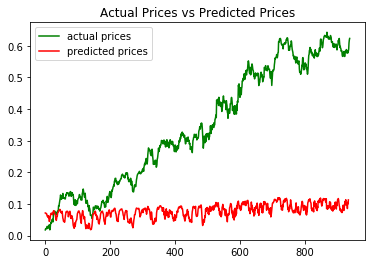

In [16]:
evaluate_model(path, train_loss_log)